In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

### Importance of Scaling Variables

Let us first generate $20$ instances where each instance is two-dimensional.

In [2]:
np.random.seed(2)
points = np.random.normal(0, 1, size=(2, 20))

If we plot them, we will have the following.

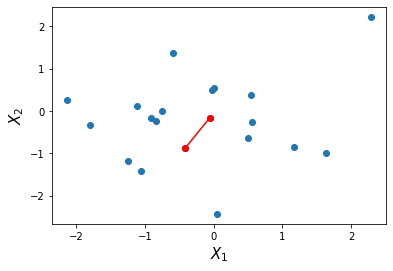

In [3]:
plt.scatter(points[0], points[1])
plt.plot(points[0][:2], points[1][:2], 'ro-')
plt.xlabel(r'$X_1$', fontsize=15)
plt.ylabel(r'$X_2$', fontsize=15)
plt.show()

Above, we have also connected two points with a line. We can see that these points are quite close to each other. Their distances in both directions are relatively close to each other.

Now, let us multiply the $x_2$ value of each point by $10$. This is equivalent to increasing the scale of the second variable. Obviously, we have not lost any information, because the original $x_2$ value can always be retrieved by dividing the new value by $10$. So, we would hope that the result of any machine learning method would not change after such a re-scaling. However, in distance-based methods (such as KNN), this is not the case. Let us see the reason next.

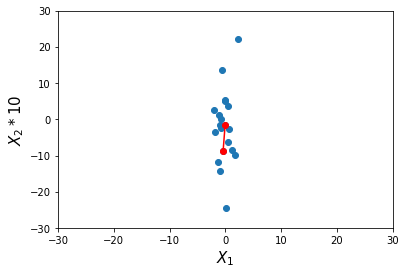

In [4]:
plt.scatter(points[0], 10*points[1])
plt.plot(points[0][:2], 10*points[1][:2], 'ro-')
plt.xlabel(r'$X_1$', fontsize=15)
plt.ylabel(r'$X_2*10$', fontsize=15)
plt.xlim([-30, 30])
plt.ylim([-30, 30])
plt.show()

As you can see, the distance is dominated by the vertical axis, and now the horizontal axis looks less important. This happened only by multiplying $x_2$ by $10$. Now think about a dataset of patient records, where some variables are some cell values between $10^{-4}$ to $10^{-6}$ and some other variables such as the age of a person can vary anywhere between $1$ to $120$. In this case all the distance will be dominated by the age, and our KNN method will just compare the ages of patients before deciding anything. Not very useful! We should keep this in mind now before starting with a KNN application.

### KNN on the `Caravan` Dataset

We use the `Caravan` dataset from the `ISLR` library. The explanation of the dataset can be found [here](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) and we download the csv file from [this GitHub repository](https://github.com/JWarmenhoven/ISLR-python).

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Caravan.csv")
df = df.drop(columns=df.columns[0])

In [6]:
df.head(3)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No


#### Let's obtain some information on the target variable

We will try to classify whether the `Purchase` variable is a 'yes' or a 'no'. We will be checking if caravan insurances have been purchased by looking at this variable. Let us inspect this variable a little bit.

In [7]:
df.Purchase.unique() #there are only "Yes" and "No"s 

array(['No', 'Yes'], dtype=object)

In [8]:
df['Purchase'].describe() #We can see that 5,474 of the 5,822 rows have "No" target -- the target is quite imbalanced.

count     5822
unique       2
top         No
freq      5474
Name: Purchase, dtype: object

In [9]:
df['Purchase'].value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [10]:
df['Purchase'].value_counts(normalize = True) #so if we always say "No", then 

No     0.940227
Yes    0.059773
Name: Purchase, dtype: float64

#### Standardize the predictors of the dataframe only (keep the target as we want to keep the 0/1 structure)

In [11]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:,:-1]),columns = df.columns[:-1]) #scale the predictors

In [12]:
round(df_scaled.mean(),3)

MOSTYPE    -0.0
MAANTHUI   -0.0
MGEMOMV     0.0
MGEMLEEF    0.0
MOSHOOFD    0.0
           ... 
AZEILPL    -0.0
APLEZIER   -0.0
AFIETS     -0.0
AINBOED     0.0
ABYSTAND   -0.0
Length: 85, dtype: float64

In [13]:
round(df_scaled.std(),3)

MOSTYPE     1.0
MAANTHUI    1.0
MGEMOMV     1.0
MGEMLEEF    1.0
MOSHOOFD    1.0
           ... 
AZEILPL     1.0
APLEZIER    1.0
AFIETS      1.0
AINBOED     1.0
ABYSTAND    1.0
Length: 85, dtype: float64

In [14]:
df_scaled["Purchase"] = df.Purchase.copy()

Technically, scaling the whole dataframe at once is not a correct approach because we will later split it as training/test datasets. For now, this is not a big deal because here we are just showing how to use KNN. However, in the future, this will be a problem. The reason is, we are peaking ahead to the test data by using it to scale the data. So, indirectly, the test set plays a role in the training steps if we scale the whole dataframe.

#### Let us create the dataframe with predictors and only the target and then sample 20% of the dataset as a test set.

In [15]:
train, test = train_test_split(df_scaled, test_size=0.2) #test_size 0.2 means 20% of the dataset will be sampled
#train.shape[0] + test.shape[0] == df.shape[0] #should be true! (why?)

In [16]:
X_train = train.drop(columns="Purchase") #drop the purchase column
y_train = train.Purchase #take the purchase column

X_test = test.drop(columns="Purchase")
y_test = test.Purchase

#### Now we are ready to fit a KNN model

In [17]:
neigh = KNeighborsClassifier(n_neighbors=1) #train a KNN with K = 1
neigh.fit(X_train, y_train) #fit it to our training set

KNeighborsClassifier(n_neighbors=1)

In [18]:
y_pred = neigh.predict(X_test) #predict the test set

In [19]:
cm_1 = confusion_matrix(y_test, y_pred)#first row of the confusion matrix will be the true "No"s and second row "Yes"s
cm_1

array([[1019,   73],
       [  64,    9]])

#### Let us write a function that takes the "K" value and returns all the statistics that we are interested in.

In [20]:
def k_stats(k, X_train, y_train, X_test, y_test):
    neigh = KNeighborsClassifier(n_neighbors=k) #train a KNN with K = 1
    neigh.fit(X_train, y_train) #fit it to our training set
    y_pred = neigh.predict(X_test) #predict the test set
    cm = confusion_matrix(y_test, y_pred)
    nr_pos = np.sum(y_pred == "Yes")
    true_neg = cm[0][0]
    true_pos = cm[1][1]
    false_pos = cm[0][1]
    false_neg = cm[1][0]
    misclassification_rate = (false_pos + false_neg)/np.sum(cm)
    precision = true_pos / (true_pos + false_pos) #out of all times we say positives what percent we are accurate
    sensitivity = true_pos / (true_pos + false_neg) #or recall (out of positives what percent can we guess)
    return nr_pos, true_pos, misclassification_rate, precision, sensitivity

#### Question: Deliverable on KNN method
Use the `k_stats` function in a for loop and report the results obtained by the KNN method for $K=1,3,5,7,9$. To this end, create a pandas dataframe with columns `K`, `number pos`, `true pos`, `misclassification`, `precision`, `sensitivity`. Analyze the misclassification vs. sensitivity tradeoff with respect to increasing $K$. Compare your results with the classifier which always says "No".

#### Answer: We construct a dataframe which includes the "K" hyperparameter and the test statistics KNN with this K achieves.

In [21]:
df_knn = pd.DataFrame(columns=['K','number pos', 'true pos', 'misclassification','precision','sensitivity'])

Here the first column is the "K" value we use. The second column, `number pos`, is the number of times our method says "Yes" for a test instance. `true pos` is the number of times these are indeed "Yes" instances (true positive classification). Moreover, we give the misclassification rate, precision, and senstivity.

In [22]:
for k in range(5):
    nr_pos, true_pos, mc, pre, sens = k_stats(2*k+1, X_train, y_train, X_test, y_test)
    df_knn.loc[k] = [2*k+1,nr_pos, true_pos, mc, pre, sens]
df_knn["K"] = pd.to_numeric(df_knn.K, downcast='integer')
df_knn["number pos"] = pd.to_numeric(df_knn["number pos"], downcast='integer')
df_knn["true pos"] = pd.to_numeric(df_knn["true pos"], downcast='integer')

In [23]:
df_knn.style.hide_index()

K,number pos,true pos,misclassification,precision,sensitivity
1,82,9,0.117597,0.109756,0.123288
3,37,7,0.082403,0.189189,0.095890
5,7,3,0.063519,0.428571,0.041096
7,3,1,0.063519,0.333333,0.013699
9,2,1,0.062661,0.500000,0.013699


Here, we can see that the more "K" we pick, the more misclassification error we get. However, see the following:

In [24]:
y_test.value_counts(normalize = True)

No     0.937339
Yes    0.062661
Name: Purchase, dtype: float64

Here we can see that even if we say "No" all the time, our misclassification rate will be already $6.6 \%$. So, the fact that having a lower misclassification rate when we increase $K$ is not very surprising, as we can observe from `df_knn` that the larger $K$ gets the less we predict "Yes". So misclassification should not be our main metric here. We might for example be interested in $K=3$ where we still have an $8.2 \%$ misclassification rate, but we still find $7$ of the positives compared to $1$ positive in the case of $K=9$. This is a decision where managerial insights will play a role.